torch.Size([140288, 3, 64, 64])


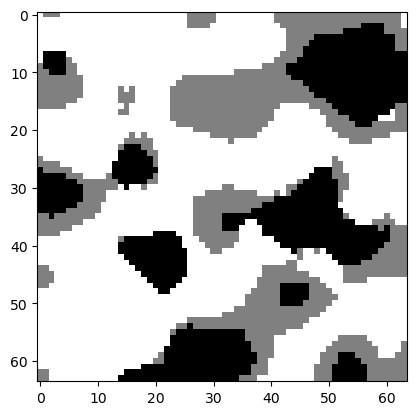

In [51]:
'''Project: SliceGAN
   Part: Preprocessing
   Author: lwj
   Date: 2024/2/21-2024/2/25'''

from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn

# Import original pictures from file
pic_list = []
i = 0
for pic_name in os.listdir('C:/Users/Bitte/Downloads/sofc/anode_segmented'):
    file_name = 'C:/Users/Bitte/Downloads/sofc/anode_segmented' + '/' + pic_name
    img = Image.open(file_name)
    img = img.convert('RGB')
    # print(img.size)
    i += 1
    if (i - 1) % 50 == 0 :
        pic_list.append(img)

# Transform pictures into nparray
pic_data_list = []
for item in pic_list:
    img_data = np.array(item)
    pic_data_list.append(img_data)
    # print(pic_data_list[0])
size = pic_data_list[0].shape
    
# Crop images(data)
divipic_data_list = []
for image in pic_data_list :
   for i in range(1 , size[0] , 8) :
        for j in range(1 , size[1] , 8) :
            if (i + 64) < size[0] and (j + 64) < size[1] and len(divipic_data_list) < 140288:
                roi = image[i : (i + 64) , j : (j + 64)]
                divipic_data_list.append(roi)
# print(divipic_data_list[0])
# print(divipic_data_list[1])
# pic_shape = divipic_data_list[0].shape
# print(pic_shape)
plt.imshow(divipic_data_list[1])

# One-hot encoding
onehot_pic_list = []

for pic in divipic_data_list:
    onehot_pic = np.transpose(pic , (2,0,1))
    onehot_pic_list.append(onehot_pic)

onehot_data = np.array(onehot_pic_list)
sample = np.unique(onehot_pic_list[0])
sample = sample.reshape(1 , -1 , 1 , 1)
channel_data = np.where(onehot_data == sample , 1 , 0)

data = torch.FloatTensor(channel_data)
dataset = torch.utils.data.TensorDataset(data)
print(data.shape)

In [52]:
'''Project: SliceGAN
   Part: Network
   Author: lwj
   Date: 2024/2/26'''


# Batch size of D & G
batch_size = 8 * 64
D_batch_size = 4 * 64

# Number of workers for dataloader
workers = 2

# The gpu available
ngpu = 1

# Load data to dataloader
dataloader = torch.utils.data.DataLoader(dataset , batch_size = D_batch_size , shuffle = True , num_workers = workers)

# Choose the device
device = torch.device('cuda:0')

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Define the Generator

# Size of the feature maps
ngf = 64

# Size of the input z vector
nz = 100

# Number of channels in the training images
nc = 3

class Generator(nn.Module):
   def __init__ (self , ngpu):
      super(Generator, self).__init__()
      self.ngpu = ngpu
      self.main = nn.Sequential(
         # input is Z, going into a convolution
         nn.ConvTranspose3d(nz, ngf * 8, 4, 2, 2, bias=False),
         nn.BatchNorm3d(ngf * 8),
         nn.ReLU(True),
         # state size. (ngf*8) x 6 x 6 x 6
         nn.ConvTranspose3d(ngf * 8, ngf * 4, 4, 2, 2, bias=False),
         nn.BatchNorm3d(ngf * 4),
         nn.ReLU(True),
         # state size. (ngf*4) x 10 x 10 x 10
         nn.ConvTranspose3d(ngf * 4, ngf * 2, 4, 2, 2, bias=False),
         nn.BatchNorm3d(ngf * 2),
         nn.ReLU(True),
         # state size. (ngf*2) x 18 x 18 x 18
         nn.ConvTranspose3d(ngf * 2, ngf, 4, 2, 2, bias=False),
         nn.BatchNorm3d(ngf),
         nn.ReLU(True),
         # state size. (ngf) x 34 x 34 x 34
         nn.ConvTranspose3d(ngf, nc, 4, 2, 3, bias=False),
         nn.Softmax(dim=1)
         # state size. (nc) x 64 x 64 x 64
      )
   def forward(self , x):
      return self.main(x)

# Define the Discriminator
   
# Size of feature maps in Discriminator
ndf = 64

class Discriminator(nn.Module):
   def __init__(self, ngpu):
      super(Discriminator, self).__init__()
      self.ngpu = ngpu
      self.main = nn.Sequential(
         # input is (nc) x 64 x 64
         nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
         nn.BatchNorm2d(ndf),
         nn.LeakyReLU(0.2, inplace=True),
         # state size. (ndf) x 32 x 32
         nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
         nn.BatchNorm2d(ndf * 2),
         nn.LeakyReLU(0.2, inplace=True),
         # state size. (ndf*2) x 16 x 16
         nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
         nn.BatchNorm2d(ndf * 4),
         nn.LeakyReLU(0.2, inplace=True),
         # state size. (ndf*4) x 8 x 8
         nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
         nn.BatchNorm2d(ndf * 8),
         nn.LeakyReLU(0.2, inplace=True),
         # state size. (ndf*8) x 4 x 4
         nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
         nn.Sigmoid()
      )

   def forward(self, x):
      return self.main(x)

netG = Generator(ngpu).to(device)    
netD = Discriminator(ngpu).to(device)
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=(

In [53]:
'''Project: SliceGAN
   Part: Training
   Author: lwj
   Date: 2024/2/26-2024/2/28'''

import random
import torch.optim as optim

# Set random seed for reproducibility.
seed = 500
random.seed(seed)
torch.manual_seed(seed)

#  Choose the loss fuction
criterion = nn.BCELoss()

# Setup the optimizer
optimD = optim.Adam(netD.parameters() , lr = 0.0001 , betas = (0.9 , 0.999))
optimG = optim.Adam(netG.parameters() , lr = 0.0001 , betas = (0.9 , 0.999))

# Create the noise
fixed_noise = torch.randn(4 , nz , 4 , 4 , 4 , device = device)

# Training process

# Label
real_label = 0.9
fake_label = 0

img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(100):
   for i , data in enumerate(dataloader , 0):
      # Train the netD
      noise = torch.randn(4 , nz , 4 , 4 , 4 , device = device)
      fake = netG(noise).detach()
      for dim , (d1 , d2 ,d3) in enumerate(zip([2, 3, 4], [3, 2, 2], [4, 4, 3])):
         # Use real data
         optimD.zero_grad()                  
         real_cpu = data[0].to(device)
         b_size = real_cpu.size(0)
         # print(real_cpu.size(3))
         label = torch.full((b_size,) , real_label , dtype = torch.float , device = device)     
         output_r = netD(real_cpu).view(-1)
         # print(output_r.shape)                     
         loss_real = criterion(output_r , label)
         # loss_real.backward()
         D_x = output_r.mean().item()
         # Use fake data
         fake_perm = fake.permute(0, d1, 1, d2, d3).reshape(D_batch_size, nc, 64, 64)
         output_f = netD(fake_perm).view(-1)
         label_f = torch.full((D_batch_size,) , fake_label , dtype = torch.float , device = device)
         loss_fake = criterion(output_f , label_f)
         # loss_fake.backward()
         D_G_z1 = output_f.mean().item()
         loss_D = loss_real + loss_fake
         loss_D.backward()
         optimD.step()

      # Train the netG
      optimG.zero_grad()
      noise = torch.randn(8 , nz , 4 , 4 , 4 , device = device)
      fake_data = netG(noise)
      loss_G = 0
      for dim , (d1 , d2 ,d3) in enumerate(zip([2, 3, 4], [3, 2, 2], [4, 4, 3])):         
         fake_data_perm = fake_data.permute(0, d1, 1, d2, d3).reshape(batch_size, nc, 64, 64)
         output_G = netD(fake_data_perm).view(-1)
         label_f = torch.full((batch_size,) , real_label , dtype = torch.float , device = device)
         loss_G = loss_G + criterion(output_G , label_f)
         D_G_z2 = output_G.mean().item()
      loss_G.backward()
      optimG.step()
      
      if i % 500 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, 100, i, len(dataloader),
                     loss_D.item(), loss_G.item(), D_x, D_G_z1, D_G_z2))
      G_losses.append(loss_G.item())
      D_losses.append(loss_D.item())
             
      iters += 1
   if epoch % 10 == 0:
      torch.save(netG.state_dict() , 'netG_epoch_{}.pt'.format(epoch))   

torch.save(netG.state_dict() , 'netG.pt')
torch.save(netD.state_dict() , 'netD.pt')

[0/100][0/548]	Loss_D: 0.6053	Loss_G: 8.7884	D(x): 0.7100	D(G(z)): 0.1184 / 0.0693
[0/100][500/548]	Loss_D: 0.3288	Loss_G: 24.9027	D(x): 0.8843	D(G(z)): 0.0001 / 0.0001
[1/100][0/548]	Loss_D: 0.3279	Loss_G: 22.4435	D(x): 0.9127	D(G(z)): 0.0002 / 0.0002
[1/100][500/548]	Loss_D: 0.3499	Loss_G: 13.4963	D(x): 0.8746	D(G(z)): 0.0069 / 0.0043
[2/100][0/548]	Loss_D: 0.3429	Loss_G: 15.3305	D(x): 0.8790	D(G(z)): 0.0058 / 0.0048
[2/100][500/548]	Loss_D: 0.3366	Loss_G: 16.0694	D(x): 0.9024	D(G(z)): 0.0038 / 0.0030
[3/100][0/548]	Loss_D: 0.3359	Loss_G: 15.9377	D(x): 0.8755	D(G(z)): 0.0013 / 0.0033
[3/100][500/548]	Loss_D: 0.3419	Loss_G: 18.8388	D(x): 0.9275	D(G(z)): 0.0050 / 0.0011
[4/100][0/548]	Loss_D: 0.3462	Loss_G: 11.0253	D(x): 0.9097	D(G(z)): 0.0084 / 0.0127
[4/100][500/548]	Loss_D: 1.1760	Loss_G: 11.3143	D(x): 0.9707	D(G(z)): 0.4868 / 0.0432
[5/100][0/548]	Loss_D: 0.3656	Loss_G: 12.6316	D(x): 0.9411	D(G(z)): 0.0141 / 0.0095
[5/100][500/548]	Loss_D: 0.3770	Loss_G: 16.9590	D(x): 0.7937	D(G(z)

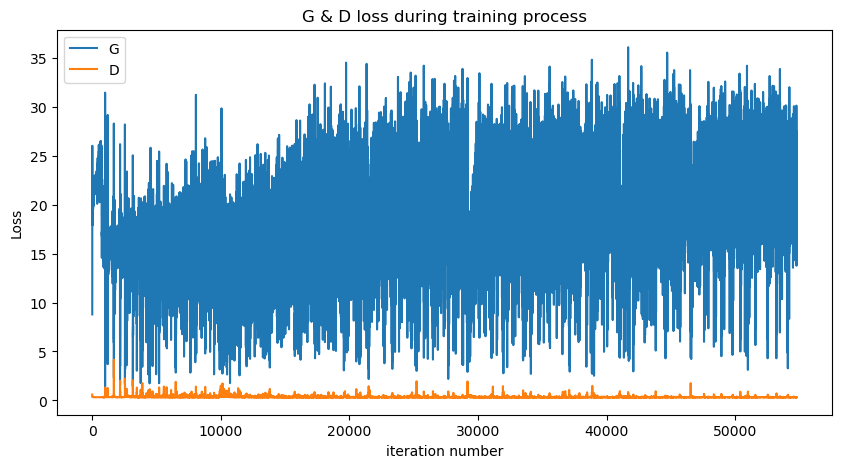

In [54]:
# Visualize the loss of D & G trend

plt.figure(figsize=(10 , 5))
plt.title('G & D loss during training process')
plt.plot(G_losses , label = 'G')
plt.plot(D_losses , label = 'D')
plt.xlabel('iteration number')
plt.ylabel('Loss')
plt.legend()
plt.show()

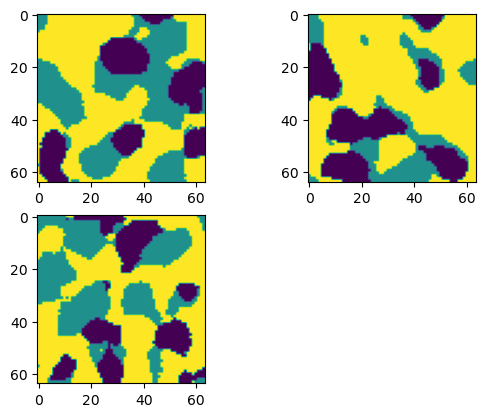

In [68]:
'''Project: SliceGAN
   Part: Postprocessing
   Author: lwj
   Date: 2024/2/28'''


import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn

# Set random seed for reproducibility.
seed = 500
random.seed(seed)
torch.manual_seed(seed)
# Test the model
m_state_dict = torch.load('netG.pt')
new_model = Generator(ngpu).to(device)
new_model.load_state_dict(m_state_dict)
fixed_noise = torch.randn(4 , nz , 4 , 4 , 4 , device = device)
predict = new_model(fixed_noise)
# Output the generated figure
fig = plt.figure()
axes = []
i = 0
for dim , (d1 , d2 ,d3) in enumerate(zip([3, 2, 4], [2, 3, 2], [4, 4, 3])):
    predict_show = predict.permute(0, d1, 1, d2, d3).reshape(64*4, nc, 64, 64)
    device = 'cpu'
    predict_show = predict_show.to(device)
    predict_show = predict_show.detach().numpy()
    phase2 = np.zeros([64 , 64 , 64])
    phase3 = np.zeros([64 , 64 , 64])
    p1 = np.array(predict_show[0][0])
    p2 = np.array(predict_show[0][1])
    p3 = np.array(predict_show[0][2])
    phase2[(p2 > p1) & (p2 > p3)] = 128  # spheres, grey
    phase3[(p3 > p2) & (p3 > p1)] = 255  # binder, white
    output_img = np.int_(phase2+phase3)
    axes.append(fig.add_subplot(2 , 2 , i + 1))
    plt.imshow(output_img[: , : , 45])
    i += 1